This notebook is designed to create the _benthos_ interpolated maps using `DIVAnd`.      
The data file was prepared by P. Herman (Deltares).

In [66]:
using DIVAnd
using PyPlot
using Proj4
using DelimitedFiles
using PyCall
using Dates
using NCDatasets
using Pkg
include("../scripts/BenthosInterp.jl")
Pkg.status("DIVAnd")

doplot = false       # set to 'true' to create the plots
doplotdata = false    # set to 'true' to plot the observations
usecartopy = true    # set to 'true' if plots are created using Cartopy
writenc = true;     # set to 'true' to write netCDF files with the results

Status `~/.julia/environments/v1.5/Project.toml`
  [efc8151c] DIVAnd v2.6.5


## Files and directories

In [40]:
figdir = "../product/figures/1-UniformL/"
outputdir = "../product/netCDF/1-UniformL/"
datadir = "../data/"
datafile = joinpath(datadir, "specs4Diva.csv")
isdir(figdir) ? "Figure directory already exists" : mkpath(figdir)
isdir(outputdir) ? "Output directory already exists" : mkpath(outputdir)
isfile(datafile) ? @info("File already downloaded") : download("https://dox.ulg.ac.be/index.php/s/vNQcvqjW8RzdNBt/download", datafile)

┌ Info: File already downloaded
└ @ Main In[40]:7


In [41]:
domain = [-16., 9., 45., 66.]; # [West East South North]
Δlon = 0.1
Δlat = 0.1

0.1

## Prepare mask
### Interpolation grid

In [42]:
longrid = domain[1]:Δlon:domain[2]
latgrid = domain[3]:Δlat:domain[4]

45.0:0.1:66.0

### Download bathymetry file

In [43]:
bathname = joinpath(datadir, "gebco_30sec_4.nc")
if !isfile(bathname)
    download("https://dox.ulg.ac.be/index.php/s/RSwm4HPHImdZoQP/download", bathname)
else
    @info("Bathymetry file already downloaded")
end

┌ Info: Bathymetry file already downloaded
└ @ Main In[43]:5


### Read bathymetry

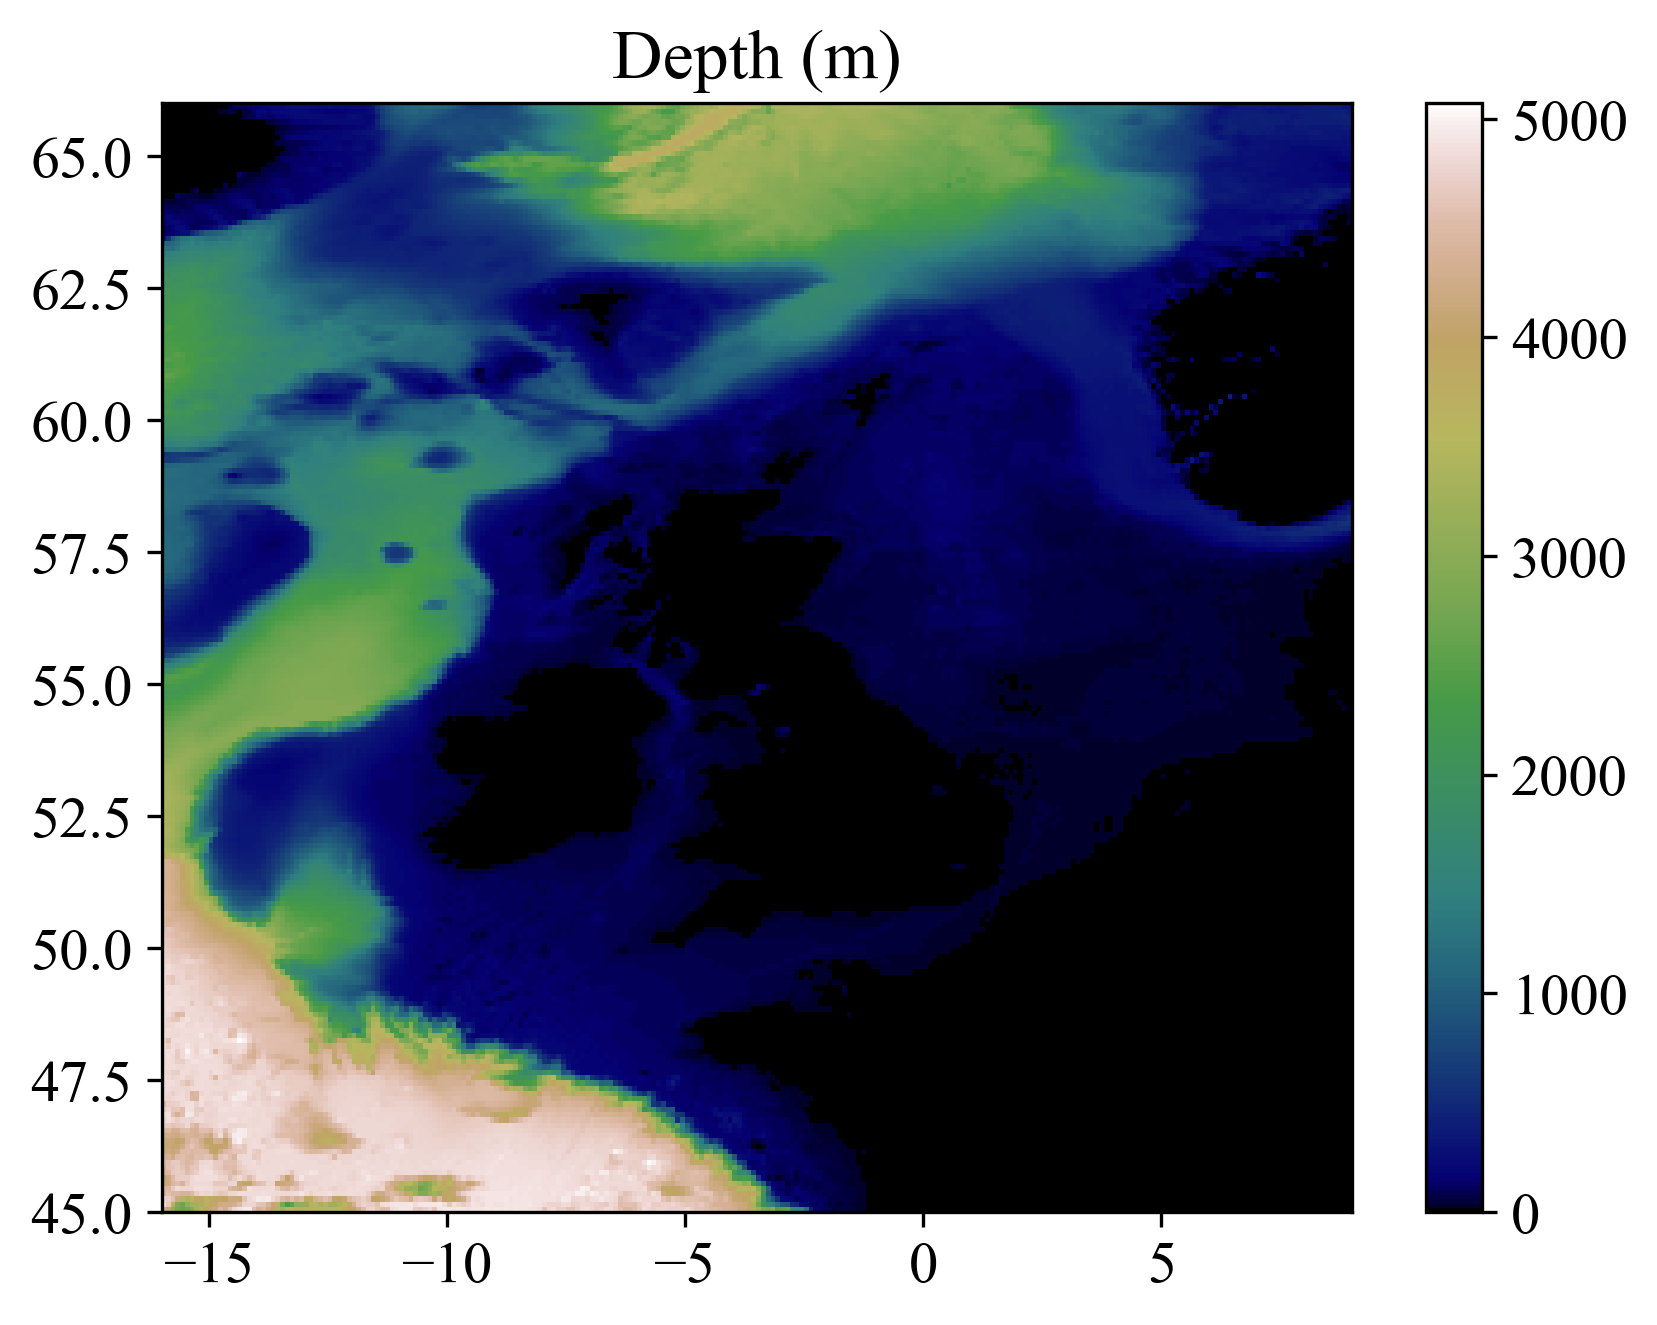

size(b) = (251, 211)


In [44]:
bx, by, b = load_bath(bathname, true, longrid, latgrid)
@show size(b)

if doplot
    fig = PyPlot.figure()
    ax = PyPlot.subplot(111)
    pcolor(bx,by,b', vmin=0., cmap=PyPlot.cm.gist_earth); 
    colorbar(orientation="vertical")
    title("Depth (m)")
    savefig(joinpath(figdir, "benthos_bathy.jpg"), dpi=300, bbox_inches="tight")
    show()
end

### Metrics

In [45]:
_, (pm, pn),(xi, yi) = DIVAnd.DIVAnd_rectdom(longrid, latgrid);
xi, yi, mask = DIVAnd.load_mask(bathname, true, longrid, latgrid, 0.0);
xx, yy = ndgrid(xi, yi);

## Interpolation
### Data reading

Loop on all the species: 
1. read the data
2. compute the heatmaps and 
3. derive the probability field as:
```
d = npre * dens2 / (npre * dens_pre + nabs * dens_abs)
```
where 
* dens_pre is the heatmap obtained with the presence data only; 
* dens_abs is the heatmap obtained with the absence data only. 

The reason for this equation is that the heatmap are computed so that their integral over the domain is 1, whatever the number of observations. 

In [46]:
# Set correlation length
Lvalues = [0.01, 0.05, 0.1, 0.5, 1.]
L = 0.1
epsilon2 = 5.

5.0

In [56]:
speciesnamelist = get_species_list(datafile)
sort!(speciesnamelist)
for species in speciesnamelist

    speciesslug = get_species_slug(String(species))
    
    @info(speciesslug)
    @info("Working on species $(String(species))");
    lon_pre, lat_pre, lon_abs, lat_abs = read_coords_species(datafile, species);
    npre = length(lon_pre)
    nabs = length(lon_abs)

    @info("Number of presence: $(npre), number of absence: $(nabs)")
    

    # Plot the data locations
    if doplotdata
        make_plot_presence_absence(lon_pre, lat_pre, lon_abs, lat_abs, String(species),
            dlat=4., dlon=6.,
            figname=joinpath(figdir, "$(speciesslug)_data.jpg"), usecartopy=true)
    end
    
    
    
    @info("Computing heatmaps")
    dens_pre, LHM2, LCV2, LSCV2 = DIVAnd_heatmap(mask, (pm,pn), (xx, yy), 
        (lon_pre, lat_pre), ones(npre), L);
    dens_abs, LHM3, LCV3, LSCV3 = DIVAnd_heatmap(mask, (pm,pn), (xx, yy), 
        (lon_abs, lat_abs), ones(nabs), L);


    d = npre .* dens_pre ./ (npre .* dens_pre .+ nabs .* dens_abs);

    
    @info("Computing error field with CPME")
    lon = [lon_pre ; lon_abs]
    lat = [lat_pre ; lat_abs]

    cpme = DIVAnd_cpme(mask, (pm, pn), (xx, yy), (lon, lat), 
        ones(length(lon)), 5. * L, epsilon2);

    
    if doplot
        
        plot_heatmap(longrid, latgrid, d, lon_pre, lat_pre, lon_abs, lat_abs,
            "$(species): probability", figname=joinpath(figdir, "$(speciesslug)_density.jpg"), 
            usecartopy=usecartopy)  
        """
        plot_error(longrid, latgrid, cpme, "$(species): error", 
            figname=joinpath(figdir, "$(speciesslug)_error.png"),
            usecartopy=usecartopy)
        """
        
    end   

    if writenc
        @info("Creating the netCDF file with results")
        create_nc_results(joinpath(outputdir, "$(speciesslug)_density.nc"), 
            longrid, latgrid, d, String(species), domain=domain);

        @info("Adding error field to netCDF file")
        write_nc_error(joinpath(outputdir, "$(speciesslug)_density.nc"), cpme);
    end


end

┌ Info: Abludomelita_obtusata
└ @ Main In[56]:7
┌ Info: Working on species Abludomelita_obtusata
└ @ Main In[56]:8
┌ Info: Column index for Abludomelita_obtusata: 9
└ @ Main /home/ctroupin/Projects/EMODnet/EMODnet-Biology-Benthos-Interpolated-Maps/scripts/BenthosInterp.jl:25
┌ Info: Number of presence: 2097, number of absence: 66463
└ @ Main In[56]:13
┌ Info: Computing heatmaps
└ @ Main In[56]:25
┌ Warning: Data array size (66463,) is larger then maximum 10000. Superobservations will be created. To avoid, increase nmax to the desired number of superobs
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/LkI0S/src/DIVAnd_heatmap.jl:48
┌ Info: Computing error field with CPME
└ @ Main In[56]:35
┌ Info: Creating the netCDF file with results
└ @ Main In[56]:57
┌ Info: Adding error field to netCDF file
└ @ Main In[56]:61
┌ Info: Abra_alba
└ @ Main In[56]:7
┌ Info: Working on species Abra_alba
└ @ Main In[56]:8
┌ Info: Column index for Abra_alba: 5
└ @ Main /home/ctroupin/Projects/EMODnet/EMODne

┌ Info: Computing error field with CPME
└ @ Main In[56]:35
┌ Info: Creating the netCDF file with results
└ @ Main In[56]:57
┌ Info: Adding error field to netCDF file
└ @ Main In[56]:61
┌ Info: Diplocirrus_glaucus
└ @ Main In[56]:7
┌ Info: Working on species Diplocirrus_glaucus
└ @ Main In[56]:8
┌ Info: Column index for Diplocirrus_glaucus: 7
└ @ Main /home/ctroupin/Projects/EMODnet/EMODnet-Biology-Benthos-Interpolated-Maps/scripts/BenthosInterp.jl:25
┌ Info: Number of presence: 4087, number of absence: 64473
└ @ Main In[56]:13
┌ Info: Computing heatmaps
└ @ Main In[56]:25
┌ Warning: Data array size (64473,) is larger then maximum 10000. Superobservations will be created. To avoid, increase nmax to the desired number of superobs
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/LkI0S/src/DIVAnd_heatmap.jl:48
┌ Info: Computing error field with CPME
└ @ Main In[56]:35
┌ Info: Creating the netCDF file with results
└ @ Main In[56]:57
┌ Info: Adding error field to netCDF file
└ @ Main In[56]:

## Variable correlation length
The correlation length parameters is now variable over the domain. It takes into account the variability in the substrate.     
The information is read from the file `substrate_gini_impurity.nc`, output of the script [`benthos_substrate.jl`](./benthos_substrate.jl).

In [59]:
figdir2 = "../product/figures/2-VariableL/"
outputdir2 = "../product/netCDF/2-VariableL/"
isdir(figdir2) ? "Figure directory already exists" : mkpath(figdir2)
isdir(outputdir2) ? "Output directory already exists" : mkpath(outputdir2)

domain2 = [-16., 9., 47., 66.]; # [West East South North]
longrid2 = domain2[1]:Δlon:domain2[2]
latgrid2 = domain2[3]:Δlat:domain2[4]

47.0:0.1:66.0

### Read variable correlation length

In [60]:
Lfile = joinpath(datadir, "substrate_gini_impurity.nc")
if !isfile(Lfile)
    download("https://dox.ulg.ac.be/index.php/s/55IVEmn2xb8zHyR/download/download", bathname)
else
    @info("Variable correlation length file already downloaded")
end

lonL, latL, g = read_substrate(Lfile);
@info(size(g));

maxlen = 0.5
minlen = 0.05
Lfield = minlen .+ (maxlen - minlen) * (1 .- g);

┌ Info: Variable correlation length file already downloaded
└ @ Main In[60]:5
┌ Info: (1479, 683)
└ @ Main In[60]:9


Re-interpolate the L field on the interpolation grid

In [70]:
bx2, by2, b2 = load_bath(bathname, true, longrid2, latgrid2)
_, (pm2, pn2), (xi, yi) = DIVAnd.DIVAnd_rectdom(longrid2, latgrid2);
xi2, yi2, mask2 = DIVAnd.load_mask(bathname, true, longrid2, latgrid2, 0.0);
xx2, yy2 = ndgrid(xi2, yi2);
@time lon_interp, lat_interp, Linterp = interp_horiz(lonL, latL, Lfield, longrid2, latgrid2);

  0.192018 seconds (152.15 k allocations: 6.035 MiB, 18.09% gc time)


Create plot

In [71]:
llonL, llatL = ndgrid(lonL, latL)
clf();
PyPlot.figure(figsize=(10, 10))
if usecartopy
    ax = PyPlot.subplot(111, projection=myproj)
else
    ax = PyPlot.subplot(111)
end
pcm = ax.pcolor(lon_interp, lat_interp, Linterp')
decorate_map_domain(ax, domain=domain2)
PyPlot.title("Correlation length field")
colorbar(pcm, shrink=0.7)
PyPlot.savefig(joinpath(figdir, "../variableL2.jpg"), dpi=300, bbox_inches="tight")
PyPlot.close();

### Loop

In [77]:
doplot = false

true

In [78]:
speciesnamelist = get_species_list(datafile)
sort!(speciesnamelist)
for species in speciesnamelist

    speciesslug = get_species_slug(String(species))
    
    @info(speciesslug)
    @info("Working on species $(String(species))");
    lon_pre, lat_pre, lon_abs, lat_abs = read_coords_species(datafile, species);
    npre = length(lon_pre)
    nabs = length(lon_abs)

    @info("Number of presence: $(npre), number of absence: $(nabs)")
    
    
    @info("Computing heatmaps")
    dens_pre, LHM2, LCV2, LSCV2 = DIVAnd_heatmap(mask2, (pm2,pn2), (xx2, yy2), 
        (lon_pre, lat_pre), ones(npre), (Linterp, Linterp));
    dens_abs, LHM3, LCV3, LSCV3 = DIVAnd_heatmap(mask2, (pm2,pn2), (xx2, yy2), 
        (lon_abs, lat_abs), ones(nabs), (Linterp, Linterp));


    d = npre .* dens_pre ./ (npre .* dens_pre .+ nabs .* dens_abs);

    @info("Computing error field with CPME")
    lon = [lon_pre ; lon_abs]
    lat = [lat_pre ; lat_abs]

    cpme = DIVAnd_cpme(mask2, (pm2, pn2), (xx2, yy2), (lon, lat), 
        ones(length(lon)), (Linterp, Linterp), 5.);

    
    if doplot
        plot_heatmap(longrid2, latgrid2, d, lon_pre, lat_pre, lon_abs, lat_abs,
            "$(species): probability", figname=joinpath(figdir2, "$(speciesslug)_density.jpg"), 
            usecartopy=usecartopy)            
        plot_error(longrid2, latgrid2, cpme, "$(species): error", 
            figname=joinpath(figdir2, "$(speciesslug)_error.png"),
            usecartopy=usecartopy)
    end   

    if writenc
        @info("Creating the netCDF file with results")
        create_nc_results(joinpath(outputdir2, "$(speciesslug)_density.nc"), 
            longrid2, latgrid2, d, String(species), domain=domain);

        @info("Adding error field to netCDF file")
        write_nc_error(joinpath(outputdir2, "$(speciesslug)_density.nc"), cpme);
    end


end

┌ Info: Abludomelita_obtusata
└ @ Main In[78]:7
┌ Info: Working on species Abludomelita_obtusata
└ @ Main In[78]:8
┌ Info: Column index for Abludomelita_obtusata: 9
└ @ Main /home/ctroupin/Projects/EMODnet/EMODnet-Biology-Benthos-Interpolated-Maps/scripts/BenthosInterp.jl:25
┌ Info: Number of presence: 2097, number of absence: 66463
└ @ Main In[78]:13
┌ Info: Computing heatmaps
└ @ Main In[78]:16
┌ Warning: Data array size (66463,) is larger then maximum 10000. Superobservations will be created. To avoid, increase nmax to the desired number of superobs
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/LkI0S/src/DIVAnd_heatmap.jl:48
┌ Info: Computing error field with CPME
└ @ Main In[78]:25
┌ Info: Creating the netCDF file with results
└ @ Main In[78]:43
┌ Info: Adding error field to netCDF file
└ @ Main In[78]:47
┌ Info: Abra_alba
└ @ Main In[78]:7
┌ Info: Working on species Abra_alba
└ @ Main In[78]:8
┌ Info: Column index for Abra_alba: 5
└ @ Main /home/ctroupin/Projects/EMODnet/EMODne

┌ Info: Computing error field with CPME
└ @ Main In[78]:25
┌ Info: Creating the netCDF file with results
└ @ Main In[78]:43
┌ Info: Adding error field to netCDF file
└ @ Main In[78]:47
┌ Info: Diplocirrus_glaucus
└ @ Main In[78]:7
┌ Info: Working on species Diplocirrus_glaucus
└ @ Main In[78]:8
┌ Info: Column index for Diplocirrus_glaucus: 7
└ @ Main /home/ctroupin/Projects/EMODnet/EMODnet-Biology-Benthos-Interpolated-Maps/scripts/BenthosInterp.jl:25
┌ Info: Number of presence: 4087, number of absence: 64473
└ @ Main In[78]:13
┌ Info: Computing heatmaps
└ @ Main In[78]:16
┌ Warning: Data array size (64473,) is larger then maximum 10000. Superobservations will be created. To avoid, increase nmax to the desired number of superobs
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/LkI0S/src/DIVAnd_heatmap.jl:48
┌ Info: Computing error field with CPME
└ @ Main In[78]:25
┌ Info: Creating the netCDF file with results
└ @ Main In[78]:43
┌ Info: Adding error field to netCDF file
└ @ Main In[78]: